In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

First, we define some functions for computing the output of the multilayer perceptron.

In [2]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

Next, we define the structure and some utility functions of our multi-layer perceptron.

In [3]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        p = self.forward(x)
        dL_dz4 = (p - np.eye(10)[y]).reshape(1,-1)  
        dZ4_dh3 = self.W4.T                        
        dH3_dz3 = np.diag(np.where(self.h3>0,1,0))
        dZ3_dh2 = self.W3.T
        dH2_dz2 = np.diag(np.where(self.h2>0,1,0))
        dZ2_dh1 = self.W2.T
        dH1_dz1 = np.diag(np.where(self.h1>0,1,0))
        dZ1_dx = self.W1.T
        return dL_dz4 @ dZ4_dh3 @ dH3_dz3 @ dZ3_dh2 @ dH2_dz2 @ dZ2_dh1 @ dH1_dz1 @ dZ1_dx
    
        
    
    def attack(self,x,y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y) using the FGSM method
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        grad_L = self.gradient(x, y)
        return x + self.eps * np.sign(grad_L)

Now, let's load the pre-trained model and the test data.

In [4]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


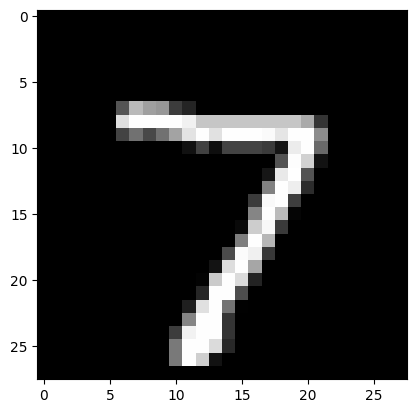

In [5]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy should be 97.6%

In [6]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


Have fun!

## Fast Gradient Sign Method

In [7]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2]
fgsm_accs = list()
nTest = 1000

for eps in epsilons:
    print("Running FGSM, eps=", eps)
    clf.set_attack_budget(eps)
    y_pred_adv = np.zeros(Y_test.shape)
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x_tilde = clf.attack(x, y)
        y_hat = clf.predict(x_tilde)
        y_pred_adv[i] = y_hat
    acc = np.sum(y_pred_adv == Y_test)*1.0/nTest
    print("Accuracy:", acc)
    fgsm_accs.append(acc)

Running FGSM, eps= 0
Accuracy: 0.976
Running FGSM, eps= 0.05
Accuracy: 0.335
Running FGSM, eps= 0.1
Accuracy: 0.014
Running FGSM, eps= 0.15
Accuracy: 0.002
Running FGSM, eps= 0.2
Accuracy: 0.0


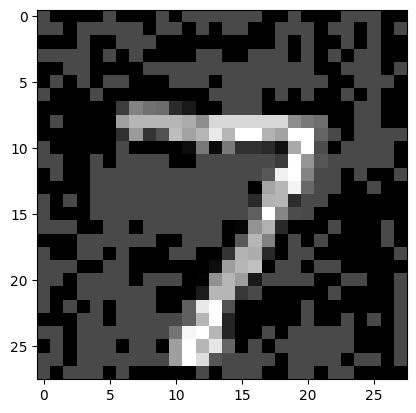

In [8]:
## Example of an adversarial image

x_dash = clf.attack(X_test[0], Y_test[0])
plt.imshow(x_dash.reshape(28, 28), cmap='gray')

In [ ]:
class IFGSM(MultiLayerPerceptron):
    '''
    This class implements the Basic Iterative Method as described in https://arxiv.org/pdf/1607.02533
    Rename heuristics for computing number of iterations (as described in the paper) 
    with a hard coded number because MNIST is a v simple dataset
    '''
    def __init__(self, N_iters: int):
        super().__init__()
        self.N_iters = N_iters
    
    def attack(self, x, y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y) using the iterative FGSM method
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        x_t = x
        for i in range(self.N_iters):
            L_grad = np.sign(self.gradient(x_t, y).flatten())
            x_t = np.clip(x_t + L_grad, x - self.eps, x + self.eps)
        return x_t

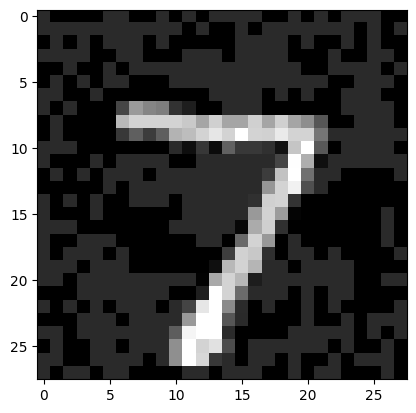

In [10]:
# Example of an adversarial image
clf = IFGSM(8)
clf.load_params(params)

x_dash = clf.attack(X_test[0], Y_test[0])
plt.imshow(x_dash.reshape(28, 28), cmap='gray')

In [11]:
clf = IFGSM(8)
clf.load_params(params)
epsilons = [0.05, 0.1, 0.15, 0.2]
ifgsm_accs = list()
nTest = 1000

for eps in epsilons:
    print("Running Iterative FGSM, eps=", eps)
    clf.set_attack_budget(eps)
    y_pred_adv = np.zeros(Y_test.shape)
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x_tilde = clf.attack(x, y)
        y_hat = clf.predict(x_tilde)
        y_pred_adv[i] = y_hat
    acc = np.sum(y_pred_adv == Y_test)*1.0/nTest
    print("Accuracy:", acc)
    ifgsm_accs.append(acc)

Running Iterative FGSM, eps= 0.05
Accuracy: 0.279
Running Iterative FGSM, eps= 0.1
Accuracy: 0.006
Running Iterative FGSM, eps= 0.15
Accuracy: 0.0
Running Iterative FGSM, eps= 0.2
Accuracy: 0.0


In [ ]:
class ILLCM(MultiLayerPerceptron):
    '''
    This class implements the Iterative Least-Likely Class Method as described in https://arxiv.org/pdf/1607.02533
    Rename heuristics for computing number of iterations (as described in the paper) 
    with a hard coded number because MNIST is a v simple dataset
    '''
    def __init__(self, N_iters: int):
        super().__init__()
        self.N_iters = N_iters
    
    def attack(self, x, y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y) using the iterative FGSM method
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        x_t = x
        logits = self.forward(x)
        y_ll = np.argmin(logits) ## Least likely class
        for i in range(self.N_iters):
            L_grad = np.sign(self.gradient(x_t, y_ll).flatten())
            x_t = np.clip(x_t - L_grad, x - self.eps, x + self.eps)
        return x_t

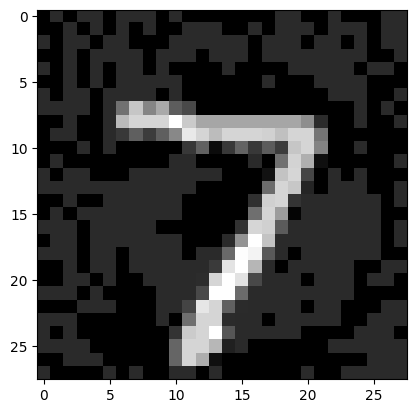

In [13]:
# Example of an adversarial image
clf = ILLCM(8)
clf.load_params(params)

x_dash = clf.attack(X_test[0], Y_test[0])
plt.imshow(x_dash.reshape(28, 28), cmap='gray')

In [14]:
clf = ILLCM(8)
clf.load_params(params)
epsilons = [0.05, 0.1, 0.15, 0.2]
illcm_accs = list()
nTest = 1000

for eps in epsilons:
    print("Running Iterative LLCM, eps=", eps)
    clf.set_attack_budget(eps)
    y_pred_adv = np.zeros(Y_test.shape)
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x_tilde = clf.attack(x, y)
        y_hat = clf.predict(x_tilde)
        y_pred_adv[i] = y_hat
    acc = np.sum(y_pred_adv == Y_test)*1.0/nTest
    print("Accuracy:", acc)
    illcm_accs.append(acc)

Running Iterative LLCM, eps= 0.05
Accuracy: 0.91
Running Iterative LLCM, eps= 0.1
Accuracy: 0.509
Running Iterative LLCM, eps= 0.15
Accuracy: 0.236
Running Iterative LLCM, eps= 0.2
Accuracy: 0.187


In [15]:
ifgsm_accs.insert(0, 0.976)
illcm_accs.insert(0, 0.976)

In [16]:
import seaborn as sns
sns.set_style('darkgrid')

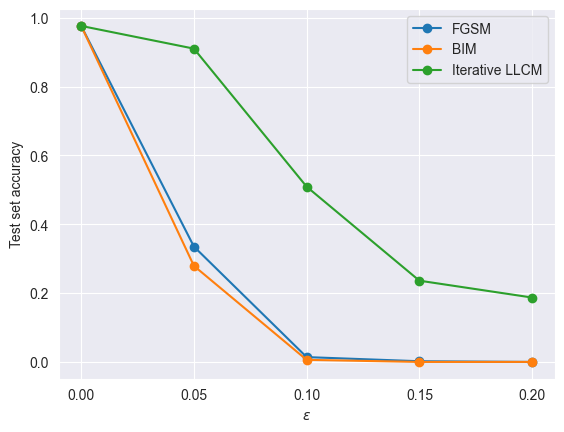

In [18]:
plt.figure()
X = [0, 0.05, 0.1, 0.15, 0.2]
plt.xticks(X)

plt.plot(X, fgsm_accs, 'o-', label='FGSM')
plt.plot(X, ifgsm_accs, 'o-', label='BIM')
plt.plot(X, illcm_accs, 'o-', label='Iterative LLCM')

plt.xlabel(r"$\epsilon$")
plt.ylabel("Test set accuracy")

plt.legend()
plt.show()